# Text analysis and agile sarcasm prediction
> Utilize classical methods to approach sarcastic sentiment classification problem

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, text analytics, machine learning, ensembling]
- image: images/sarcasm_confusion.jpeg

# Tradiontional approach to tackle sarcasm detection

In [28]:
import re
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import casual_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
import spacy


In [5]:
# !unzip archive.zip

In [6]:
df_sarcasm_1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df_sarcasm_2 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

display(df_sarcasm_1.head())
print("===============")
display(df_sarcasm_2.head())

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
print("df1_shape:", df_sarcasm_1.shape)
print("df2_shape:", df_sarcasm_2.shape)
#Combine two dataframe into one
df_sarcasm = pd.concat([df_sarcasm_1, df_sarcasm_2]).reset_index(drop=True)
del df_sarcasm_1, df_sarcasm_2
df_sarcasm.drop(['article_link'], inplace=True, axis=1)
print("df_shape:", df_sarcasm.shape)
df_sarcasm.head()

df1_shape: (26709, 3)
df2_shape: (28619, 3)
df_shape: (55328, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
#Check missing values
df_sarcasm.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

# Basic text propertires between headlines and sarcasm in this dataset

## Balance of target label

<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

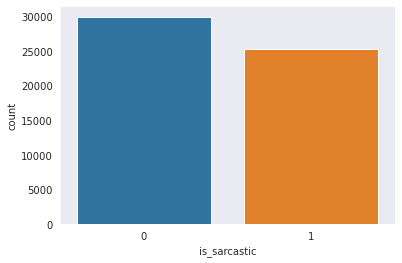

In [9]:
sns.set_style("dark")
sns.countplot(data=df_sarcasm, x='is_sarcastic')

This dataset seems not so imbalanced to affect performance the chosen machine learning algorithms.

## Sentence Length

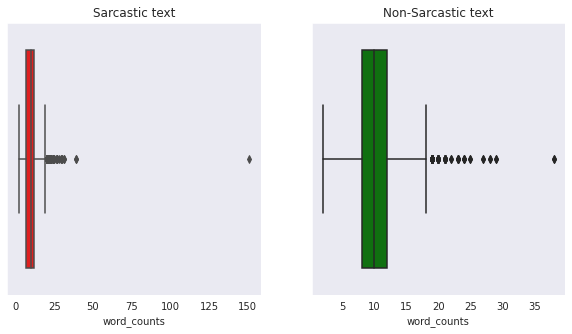

In [10]:
df_sarcasm['word_counts'] = df_sarcasm.headline.str.split().apply(len)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# axs[0].hist(word_counts.values, color='red', range=(2, 5))
sns.boxplot(data=df_sarcasm.loc[df_sarcasm.is_sarcastic == 1], x='word_counts', color='red', ax=axs[0])
# sns.boxplot(data=df_sarcasm.loc[(df_sarcasm.is_sarcastic == 1) & (df_sarcasm.word_counts < 50)], x='word_counts', color='red', ax=axs[0])
axs[0].set_title('Sarcastic text')
# axs[1].hist(word_counts, color='green')
sns.boxplot(data=df_sarcasm.loc[df_sarcasm.is_sarcastic == 0], x='word_counts', color='green',ax=axs[1])
axs[1].set_title('Non-Sarcastic text')
df_sarcasm.drop(columns=['word_counts'], inplace=True)
plt.show()

If we remove the outlier(more than 150 words) in sarcastic text group, sarcastic and non-sarcastic texts actually share similiar word counts distribution

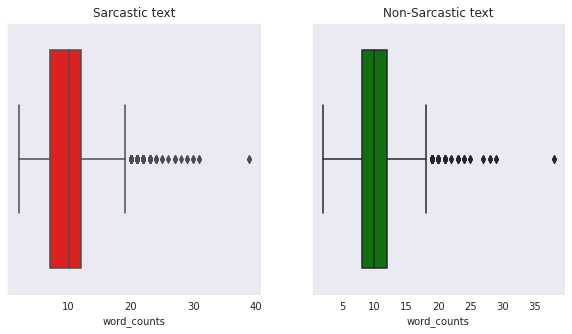

In [11]:
df_sarcasm['word_counts'] = df_sarcasm.headline.str.split().apply(len)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=df_sarcasm.loc[(df_sarcasm.is_sarcastic == 1) & (df_sarcasm.word_counts < 50)], x='word_counts', color='red', ax=axs[0])
axs[0].set_title('Sarcastic text')
sns.boxplot(data=df_sarcasm.loc[df_sarcasm.is_sarcastic == 0], x='word_counts', color='green',ax=axs[1])
axs[1].set_title('Non-Sarcastic text')
df_sarcasm.drop(columns=['word_counts'], inplace=True)
plt.show()

# EDA

Chart below shows most frequent words in our corpus.

<AxesSubplot:>

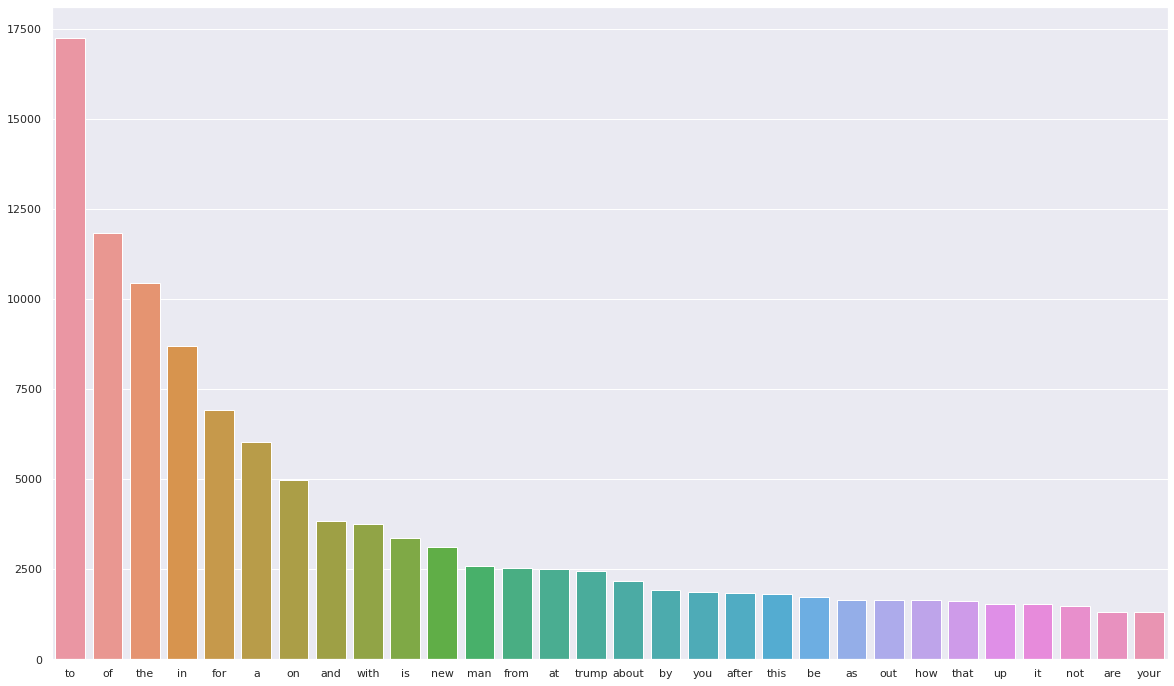

In [12]:
# Top 30 words of in corpus including stop words
all_words = df_sarcasm.headline.str.split(expand=True).unstack().value_counts()[:30]
sns.set(rc={'figure.figsize':(20, 12)})
sns.barplot(all_words.index, all_words.values)

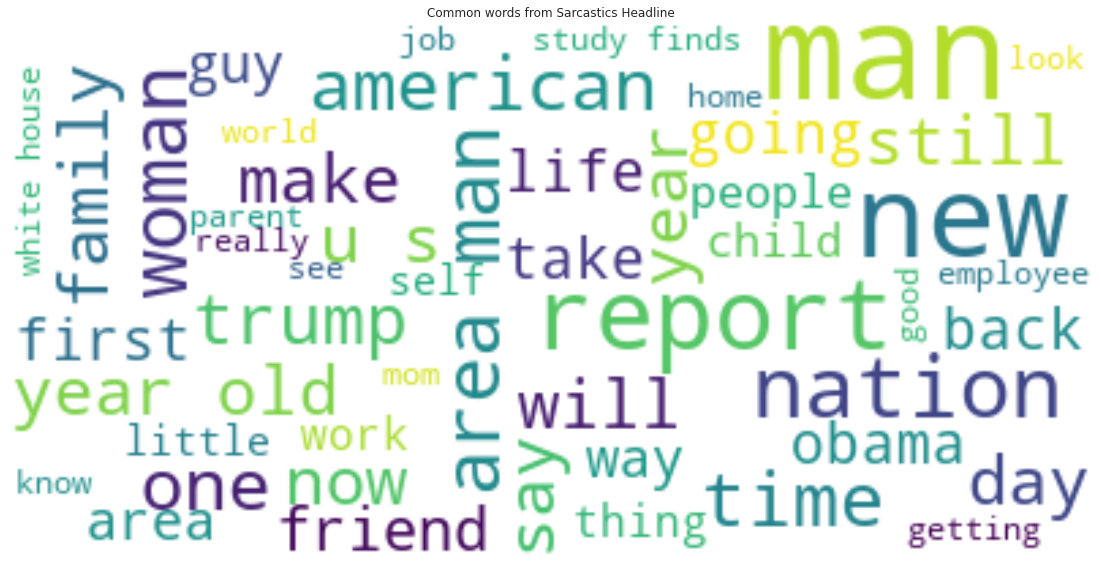

In [13]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(df_sarcasm.loc[df_sarcasm.is_sarcastic == 1].headline.str.cat(sep=' '))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Common words from Sarcastics Headline')
plt.show()

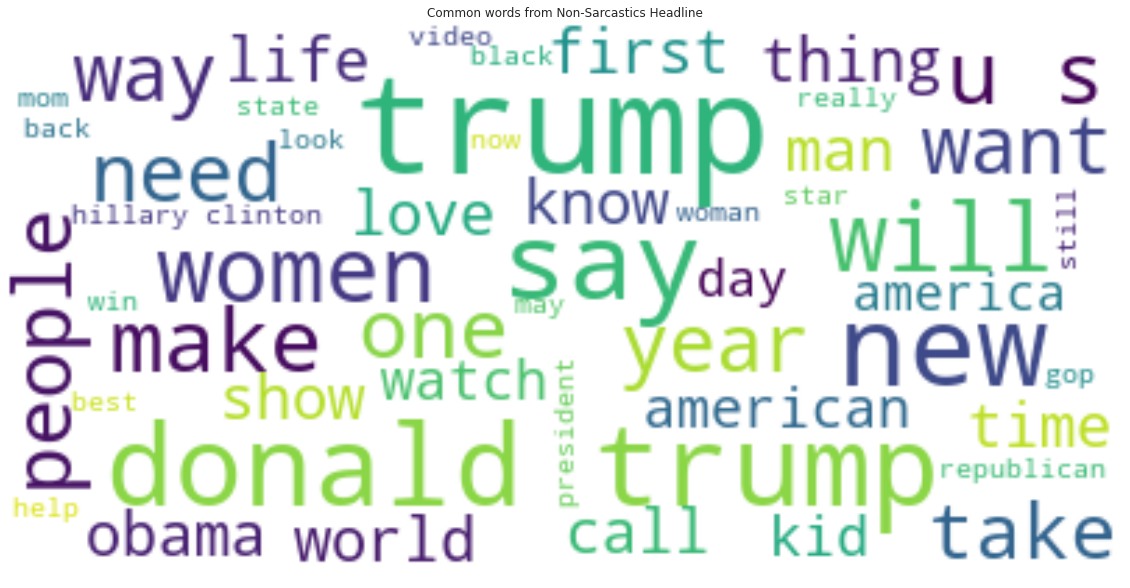

In [14]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(df_sarcasm.loc[df_sarcasm.is_sarcastic == 0].headline.str.cat(sep=' '))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Common words from Non-Sarcastics Headline')
plt.show()

# Baseline Models

In [15]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df_sarcasm.headline, df_sarcasm.is_sarcastic, random_state=12020)

In [16]:
def cross_validation(pipeline, data, label):
    models = []
    kf = KFold(n_splits=5)
    mean_score = []
    for train_index, valid_index in kf.split(data):
        X_train, y_train = data.iloc[train_index], label.iloc[train_index]
        X_valid, y_valid = data.iloc[valid_index], label.iloc[valid_index]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_valid)
        models.append(pipeline)
        # y_special = pipeline.predict(np.array(["Well, if you want to see less of me, maybe we should go out again"]))
        # print("y_special:", y_special)
        print('Precision: %.3f' % precision_score(y_true=y_valid, y_pred=y_pred))
        print('Recall: %.3f' % recall_score(y_true=y_valid, y_pred=y_pred))
        print('F1: %.3f' % f1_score(y_true=y_valid, y_pred=y_pred))
        score = accuracy_score(y_true=y_valid, y_pred=y_pred)
        print('Accuracy: %.3f' % score)
        mean_score.append(score)
        # sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True)
        # plt.show()
        print("================================")
    print(f"Finished, average accuracy is {np.mean(np.array(mean_score))}")


In [17]:
def Testset_Performance(text_preprocess, classifier, cv=False):
    pipe = Pipeline([text_preprocess,
                     classifier,
    ])
    if cv == True:
      cross_validation(pipe, X_train, y_train)
    # set_trace()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
    plt.show()
    print('Test Set Accuracy: %.3f' % score)

In [18]:
# Multinomial Naive Bayes + CountVectorizer Default Settings
pipe = Pipeline([('count_vect', CountVectorizer()), ('clf', MultinomialNB())])
cross_validation(pipe, X_train, y_train)

Precision: 0.886
Recall: 0.868
F1: 0.877
Accuracy: 0.890
Precision: 0.888
Recall: 0.867
F1: 0.877
Accuracy: 0.891
Precision: 0.895
Recall: 0.864
F1: 0.879
Accuracy: 0.889
Precision: 0.892
Recall: 0.874
F1: 0.883
Accuracy: 0.892
Precision: 0.892
Recall: 0.861
F1: 0.876
Accuracy: 0.888
Finished, average accuracy is 0.8898689114815692


In [19]:
# Multinomial Naive Bayes + Tf-idf Default Settings
pipe = Pipeline([('tfidf_vect', TfidfVectorizer()), ('clf', MultinomialNB())])
cross_validation(pipe, X_train, y_train)

Precision: 0.907
Recall: 0.813
F1: 0.857
Accuracy: 0.877
Precision: 0.914
Recall: 0.800
F1: 0.853
Accuracy: 0.876
Precision: 0.920
Recall: 0.802
F1: 0.857
Accuracy: 0.875
Precision: 0.914
Recall: 0.812
F1: 0.860
Accuracy: 0.877
Precision: 0.915
Recall: 0.806
F1: 0.857
Accuracy: 0.876
Finished, average accuracy is 0.8762290071238079


In [20]:
# Logistic Regression + CountVectorizer Default Settings
pipe = Pipeline([('count_vect', CountVectorizer()), ('clf', LogisticRegression(max_iter=200))])
cross_validation(pipe, X_train, y_train)

Precision: 0.903
Recall: 0.893
F1: 0.898
Accuracy: 0.908
Precision: 0.903
Recall: 0.888
F1: 0.896
Accuracy: 0.906
Precision: 0.908
Recall: 0.889
F1: 0.899
Accuracy: 0.906
Precision: 0.900
Recall: 0.892
F1: 0.896
Accuracy: 0.904
Precision: 0.911
Recall: 0.883
F1: 0.897
Accuracy: 0.906
Finished, average accuracy is 0.9062318787137947


In [21]:
# Logistic Regression + Tf-idf Default Settings
pipe = Pipeline([('tfidf_vect', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=200))])
cross_validation(pipe, X_train, y_train)

Precision: 0.867
Recall: 0.873
F1: 0.870
Accuracy: 0.882
Precision: 0.866
Recall: 0.872
F1: 0.869
Accuracy: 0.881
Precision: 0.875
Recall: 0.870
F1: 0.872
Accuracy: 0.881
Precision: 0.867
Recall: 0.877
F1: 0.872
Accuracy: 0.880
Precision: 0.867
Recall: 0.863
F1: 0.865
Accuracy: 0.876
Finished, average accuracy is 0.8801329874262684


In [22]:
# Linear SVC + CountVectorizer Default Settings
pipe = Pipeline([('count_vect', CountVectorizer()), ('clf', LinearSVC(random_state=0, tol=1e-5))])
cross_validation(pipe, X_train, y_train)

Precision: 0.923
Recall: 0.906
F1: 0.914
Accuracy: 0.923
Precision: 0.921
Recall: 0.909
F1: 0.915
Accuracy: 0.924
Precision: 0.925
Recall: 0.903
F1: 0.914
Accuracy: 0.921
Precision: 0.919
Recall: 0.912
F1: 0.915
Accuracy: 0.921
Precision: 0.928
Recall: 0.896
F1: 0.912
Accuracy: 0.920
Finished, average accuracy is 0.9217755601270003


In [23]:
# Logistic Regression + Tf-idf Default Settings
pipe = Pipeline([('tfidf_vect', TfidfVectorizer()), ('clf', LinearSVC(random_state=0, tol=1e-5))])
cross_validation(pipe, X_train, y_train)

Precision: 0.913
Recall: 0.909
F1: 0.911
Accuracy: 0.920
Precision: 0.910
Recall: 0.907
F1: 0.909
Accuracy: 0.917
Precision: 0.916
Recall: 0.903
F1: 0.909
Accuracy: 0.916
Precision: 0.912
Recall: 0.911
F1: 0.912
Accuracy: 0.918
Precision: 0.918
Recall: 0.899
F1: 0.909
Accuracy: 0.917
Finished, average accuracy is 0.9175341723563732


# Refine Corpus

## Improve model with N-grams and different tokenization

In [24]:
# CountVectorizer + 1-grams to 3-grams + casual tokenizer
pipe = Pipeline([('count_vect', CountVectorizer(ngram_range=(1, 3), tokenizer=casual_tokenize)),
                      ('clf', MultinomialNB())])
cross_validation(pipe, X_train, y_train)

Precision: 0.953
Recall: 0.921
F1: 0.937
Accuracy: 0.944
Precision: 0.953
Recall: 0.922
F1: 0.937
Accuracy: 0.944
Precision: 0.959
Recall: 0.912
F1: 0.935
Accuracy: 0.941
Precision: 0.964
Recall: 0.921
F1: 0.942
Accuracy: 0.947
Precision: 0.962
Recall: 0.909
F1: 0.935
Accuracy: 0.941
Finished, average accuracy is 0.9435608180402053


In [25]:
pipe = Pipeline([('count_vect', CountVectorizer(ngram_range=(1, 3), tokenizer=casual_tokenize)),
                      ('clf', LogisticRegression(max_iter=200))])
cross_validation(pipe, X_train, y_train)

Precision: 0.934
Recall: 0.944
F1: 0.939
Accuracy: 0.945
Precision: 0.939
Recall: 0.935
F1: 0.937
Accuracy: 0.943
Precision: 0.938
Recall: 0.937
F1: 0.937
Accuracy: 0.942
Precision: 0.940
Recall: 0.946
F1: 0.943
Accuracy: 0.947
Precision: 0.950
Recall: 0.929
F1: 0.939
Accuracy: 0.945
Finished, average accuracy is 0.9442596770985618


## Lemmatization

In [35]:
!python3 -m spacy download en
spacy.load('en')
lemmatizer = spacy.lang.en.English()

def my_tokenizer(doc):
  tokens = lemmatizer(doc)
  return ([token.lemma_ for token in tokens])

     |████████████████████████████████| 12.0 MB 6.6 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=89b01d29ab8a84f3f8e9253fea99c530bdc98da06f02e3f0c5ddcc892a36acaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-2uktv1mr/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/jason/anaconda3/envs/sarcasm_prediction/lib/python3.7/site-packages/en_core_web_sm
-->
/home/jason/anaconda3/envs/sarcasm_prediction/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [36]:
# Tokenize words with Lemmatization and 1 to 3-grams 
custom_vec = CountVectorizer(tokenizer=my_tokenizer, ngram_range=(1, 3))
estimators = [('tokenizer', custom_vec), 
                    ('clf', MultinomialNB())]
pipe = Pipeline([estimators[0], estimators[1]])
cross_validation(pipe, X_train, y_train)

Precision: 0.952
Recall: 0.926
F1: 0.938
Accuracy: 0.945
Precision: 0.954
Recall: 0.915
F1: 0.934
Accuracy: 0.942
Precision: 0.959
Recall: 0.913
F1: 0.935
Accuracy: 0.941
Precision: 0.962
Recall: 0.922
F1: 0.941
Accuracy: 0.947
Precision: 0.961
Recall: 0.910
F1: 0.935
Accuracy: 0.941
Finished, average accuracy is 0.9431511039942395


In conclusion, casual tokenization is slightly better than lemmatizatoin, so we will use casual tokenizer to emsemble our models.

# Stacking Classifiers

Stacking method as many people have known are one of many powerful ways to reduce biases of prediction of each estimator. Here, we use stacking method to ensemble two estimators, specifically two predictions from two estimators 'MNB' and 'Logi' will act as inputs to train our last classifier(LinearSVC) to produce final prediction.

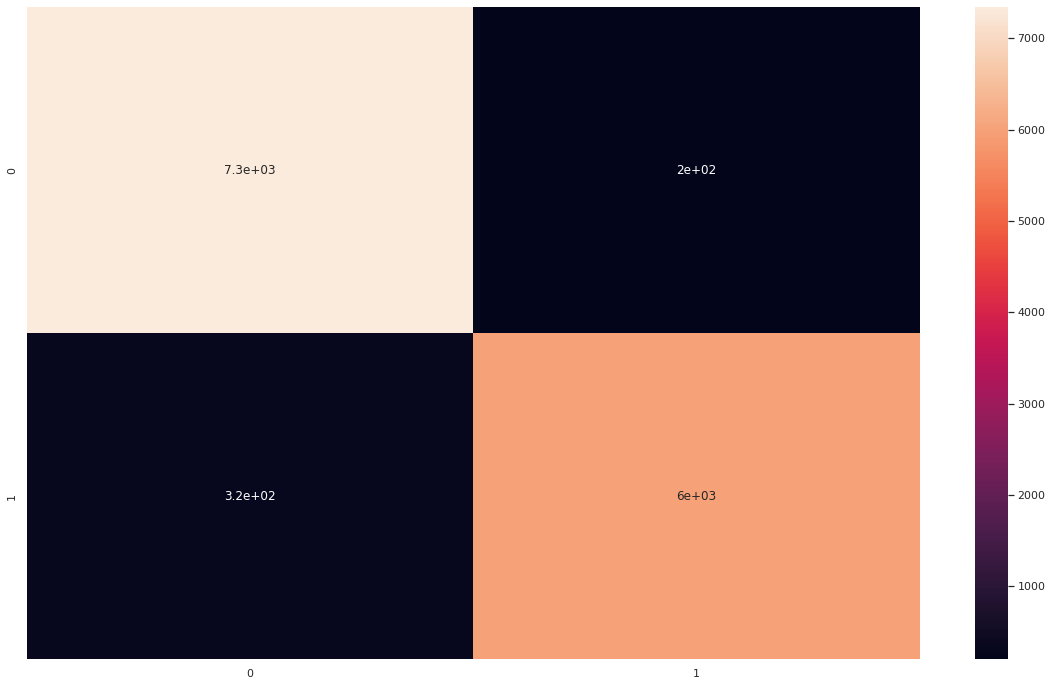

0.9627674956622325


In [37]:
estimators = [
    ('MNB', make_pipeline(CountVectorizer(ngram_range=(1, 5), tokenizer=casual_tokenize),
                          MultinomialNB())),
    ('Logi', make_pipeline(CountVectorizer(ngram_range=(1, 3), tokenizer=casual_tokenize),
                LogisticRegression(max_iter=200))),
    # ('svr', make_pipeline(CountVectorizer(ngram_range=(1, 3), tokenizer=casual_tokenize),
    #                       LinearSVC(random_state=0, tol=1e-5, max_iter=500)))
]

clf = StackingClassifier(
    # estimators=estimators, final_estimator=LogisticRegression(max_iter=200))
    estimators=estimators, final_estimator=LinearSVC(random_state=0, tol=1e-5, max_iter=500))
# clf.fit(X_train, y_train).score(X_test, y_test)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_true=y_test, y_pred=y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()
print(score)


In this notebook, utilizting this traditional NLP approach, we improve accuracy of sarcasm sentiments detection from 88.9% to 96.2%.

In [40]:
import pickle
file = open('stacking_classifiers.pkl', 'wb')

pickle.dump(clf, file)

In [44]:
y_pred = clf.predict(["Hello jason"])

In [45]:
y_pred

array([0])